In [1]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
%matplotlib inline

df = pd.read_csv("./project_data.csv")

In [2]:
import seaborn
seaborn.set()

In [3]:
def prep_data(df):
    X = df.copy()
    X.drop(columns = ['c10'], inplace=True)
    
    X.loc[X.b1 == -1, 'b1'] = np.nan
    X['b1'] = (X.b1 == 'yes').astype(float)
    X['b2'] = (X.b2 == 'yes').astype(float)
    
    X.loc[X.c3 == 'unknown','c3'] = np.nan
    X['c3'] = (X.c3 == 'True').astype(float)
    X['c4'] = (X.c4 == 'new').astype(float)
    X['c8'] = (X.c8 == 'yes').astype(float)
    
    
    X['n4_nan'] = (X.n4 == 999).astype(int)
    
    employment = X.pop('employment')
    
    X['employment_leisure'] = (employment == 'leisure').astype(int)
    X['employment_student'] = (employment == 'student').astype(int)
    
    y = (X.pop('successful_sell') == 'yes').astype(int)
    X['school'] = X.school.str.split().str[0].astype(float).fillna(-1)
    
    return X, y

In [4]:
X, y = prep_data(df)

In [5]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X,y, shuffle=True, train_size=.75)

In [6]:
X_train.columns

Index(['age', 'b1', 'b2', 'c3', 'c4', 'c8', 'dow', 'i1', 'i2', 'i3', 'i4',
       'i5', 'marriage-status', 'month', 'n2', 'n3', 'n4', 'n5', 'n6',
       'school', 'n4_nan', 'employment_leisure', 'employment_student'],
      dtype='object')

In [7]:
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.linear_model import LogisticRegressionCV
import category_encoders as ce


In [8]:
X_train.i3.value_counts().sort_index()

-50.8      96
-50.0     215
-49.5     148
-47.1    1836
-46.2    4349
-45.9       7
-42.7    5024
-42.0    2732
-41.8    3257
-40.8     531
-40.4      53
-40.3     230
-40.0     151
-39.8     172
-38.3     180
-37.5     230
-36.4    5797
-36.1    3900
-34.8     203
-34.6     126
-33.6     142
-33.0     132
-31.4     552
-30.1     275
-29.8     203
-26.9     350
Name: i3, dtype: int64

In [9]:
from sklearn.preprocessing import Binarizer, KBinsDiscretizer, RobustScaler, OneHotEncoder, PolynomialFeatures, MinMaxScaler
from sklearn.impute import SimpleImputer

In [10]:
ct = ColumnTransformer([
    ('i1', Binarizer(threshold=0), ['i1']),
    ('i3', Binarizer(threshold=-47), ['i3']),
    ('i5', Binarizer(threshold=5090), ['i5']),
    ('n6', Binarizer(threshold=0), ['n6']),
    ('n2', RobustScaler(), ['n2']),
    ('i4', KBinsDiscretizer(n_bins = 10), ['i4']),
    ('age', KBinsDiscretizer(n_bins = 10), ['age']),
    ('passthrough', 'passthrough', ['c4', 'c8', 'n4_nan', 'employment_leisure', 'employment_student']),
], remainder = 'drop', sparse_threshold=0)

clf = LogisticRegressionCV(scoring = 'roc_auc', Cs=np.logspace(-6,-2,10), max_iter=1000)

In [11]:
ct.fit_transform(X_train)

array([[1., 1., 1., ..., 1., 0., 0.],
       [1., 1., 1., ..., 1., 0., 0.],
       [1., 1., 1., ..., 1., 0., 0.],
       ...,
       [0., 1., 1., ..., 1., 0., 0.],
       [0., 1., 1., ..., 1., 0., 0.],
       [0., 1., 1., ..., 1., 0., 0.]])

In [12]:
columns = ['i1', 'i3', 'i5', 'n6', 'n2', ] + [f'i4{i}' for i in range(10)]+ [f'age{i}' for i in range(10)] + ['c4', 'c8', 'n4_nan', 'employment_leisure', 'employment_student']

Xt_train = pd.DataFrame(ct.fit_transform(X_train), columns =  columns, index = X_train.index)
Xt_test = pd.DataFrame(ct.transform(X_test), columns =  columns, index = X_test.index)

In [13]:
model = Pipeline([("ct", ct), ('clf', clf)])

In [14]:
model.fit(X_train, y_train,);

<AxesSubplot:>

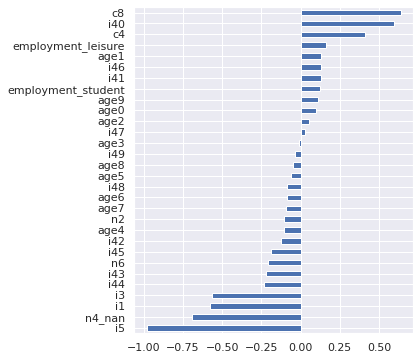

In [15]:
plt.figure(figsize = (5,6))
pd.Series(
model.steps[1][1].coef_[0],index= columns
).sort_values().plot.barh()

In [16]:
len(columns)

30

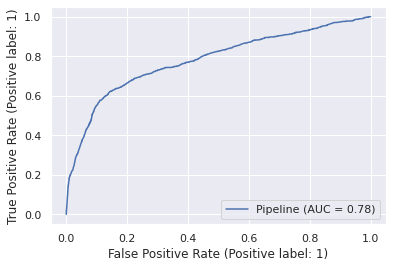

In [17]:
from sklearn.metrics import plot_roc_curve

plot_roc_curve(model, X_test, y_test)

In [18]:
y_pred = model.predict(X_test)

In [19]:
from sklearn.metrics import classification_report

print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.91      0.99      0.95      9151
           1       0.69      0.19      0.30      1146

    accuracy                           0.90     10297
   macro avg       0.80      0.59      0.62     10297
weighted avg       0.88      0.90      0.87     10297



In [20]:
from sklearn.metrics import confusion_matrix

confusion_matrix(y_test, y_pred)

array([[9049,  102],
       [ 924,  222]])

In [21]:
import shap

In [22]:
clf = model.named_steps['clf']

In [23]:
explainer = shap.Explainer(clf, Xt_train)

In [24]:
shap_values = explainer(Xt_test, )

In [25]:
def group_shap(shap_values, X, Xt, column):
    df = Xt.filter(like=column, axis='columns')
    grouping = {c:column for c in df}
    shap_values_g = shap_values.sum(axis=1,grouping=grouping)
    
    idx = shap_values_g.feature_names.index(column)

    shap_values_g.data[:, idx] =  ce.OrdinalEncoder().fit_transform(X_test[column]).values.squeeze()
    
    return shap_values_g

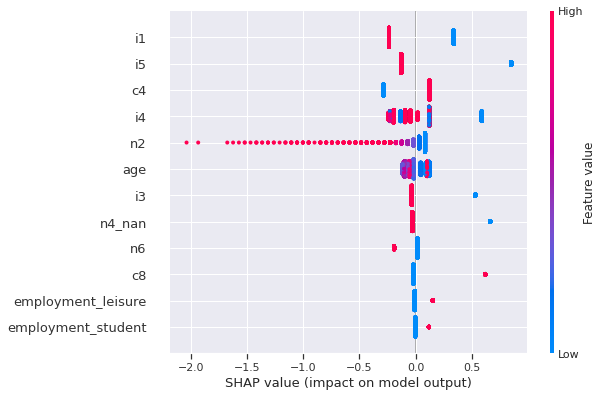

In [26]:
shap_values_g = group_shap(shap_values,  X_test, Xt_test, 'i4')
shap_values_g = group_shap(shap_values_g,  X_test, Xt_test, 'age')

shap.plots.beeswarm(shap_values_g, max_display=20)

In [27]:
#shap_values_g.display_data = X_test[shap_values_g.feature_names].values
shap_values_g.data = X_test[shap_values_g.feature_names].values

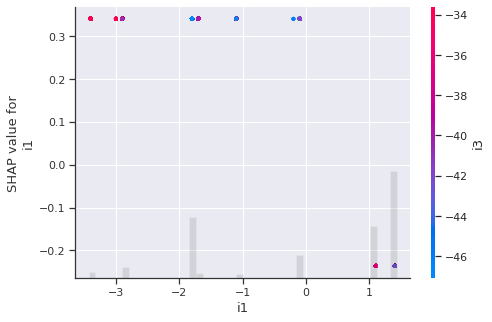

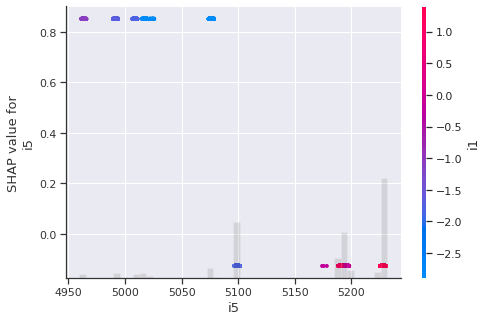

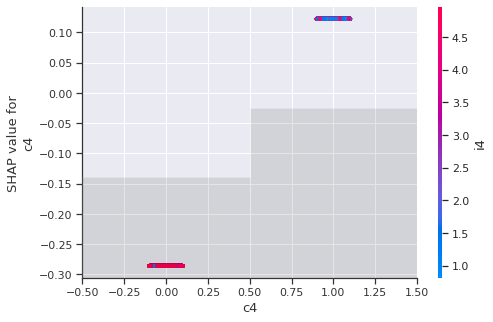

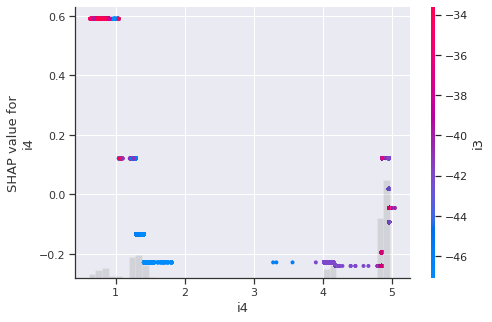

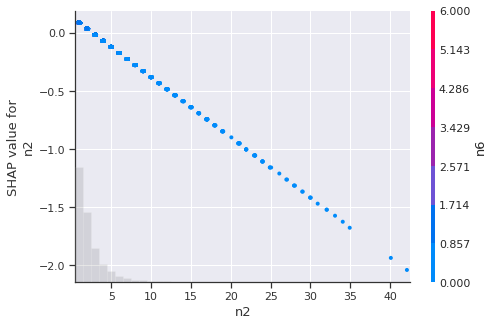

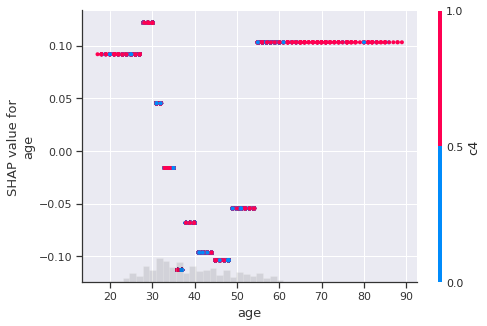

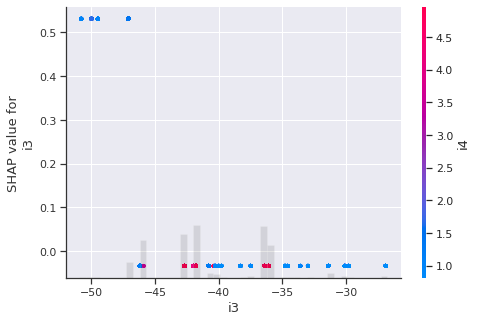

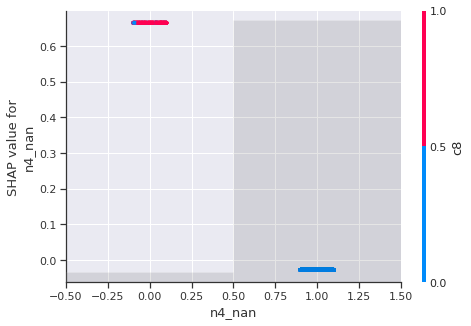

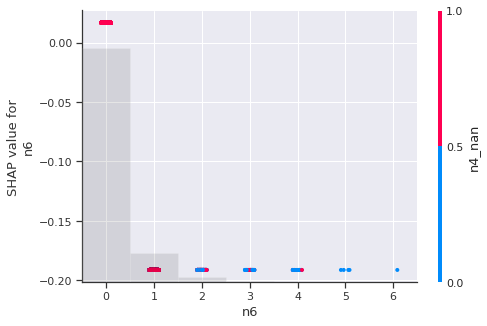

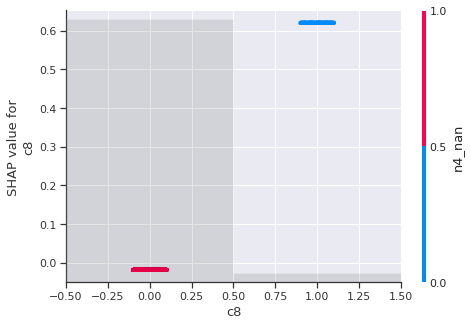

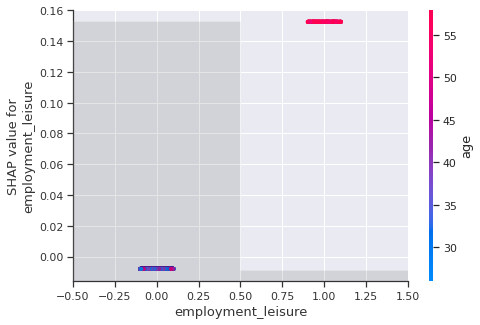

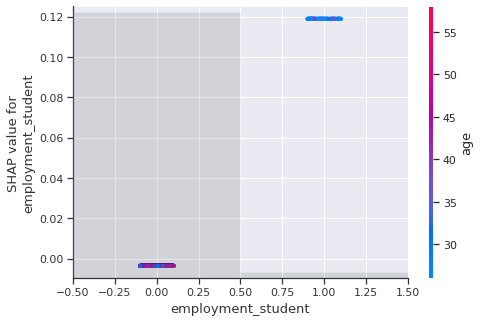

In [28]:
for f in reversed(shap_values_g.abs.sum(0).argsort.values):
    shap.plots.scatter(shap_values_g[:, f], color=shap_values_g)

In [29]:
y_pred_proba = model.predict_proba(X_test)[:, 1]

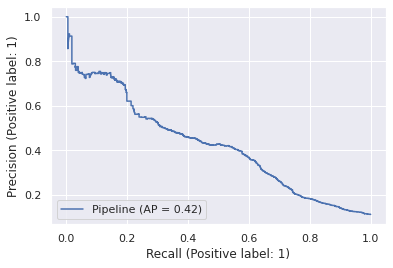

In [30]:
from sklearn.metrics import plot_precision_recall_curve

plot_precision_recall_curve(model, X_test, y_test)

In [31]:
scores = pd.DataFrame(dict(successful_sale=y_test, score= y_pred_proba))
scores['score_group'] = pd.qcut(scores.score, 20)

In [32]:
actual = scores.groupby('score_group').successful_sale.mean()
fitted = scores.groupby('score_group').score.mean()
actual /= y_test.mean()
fitted /= y_test.mean()
actual -= 1
fitted -= 1

In [33]:
actual.index = [f'ScoreGroup{i}' for i in range(1, 1+len(actual))]

(-1.0, 20.0)

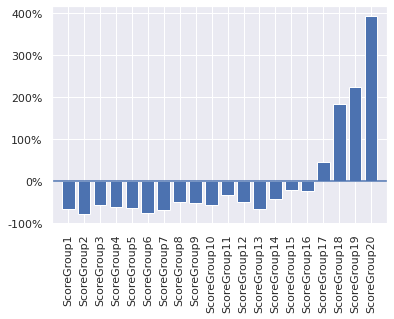

In [34]:
from  matplotlib.ticker import PercentFormatter
plt.bar(actual.index, actual.values)
plt.hlines(0,-1,21)
plt.xticks(rotation=90);
yticks = [-1, 0, 1, 2, 3, 4]
ylabels = [f'{i:.0%}' for i in yticks]
plt.yticks(yticks, ylabels)
plt.xlim(-1,20)

(array([2.856e+03, 3.957e+03, 1.436e+03, 6.290e+02, 1.380e+02, 5.500e+01,
        1.330e+02, 1.920e+02, 1.980e+02, 1.880e+02, 1.220e+02, 6.700e+01,
        3.700e+01, 3.200e+01, 1.900e+01, 9.400e+01, 8.600e+01, 4.600e+01,
        2.000e+00, 1.000e+01]),
 array([0.00517172, 0.04579028, 0.08640885, 0.12702741, 0.16764597,
        0.20826453, 0.24888309, 0.28950165, 0.33012021, 0.37073877,
        0.41135733, 0.45197589, 0.49259445, 0.53321301, 0.57383157,
        0.61445013, 0.65506869, 0.69568725, 0.73630581, 0.77692437,
        0.81754293]),
 <BarContainer object of 20 artists>)

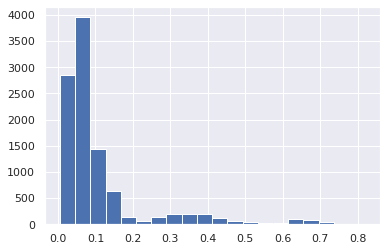

In [35]:
plt.hist(y_pred_proba, bins=20)

In [36]:
sale_rate = scores.sort_values(by='score', ascending=False).successful_sale.cumsum().reset_index(drop=True) / pd.RangeIndex(1,1+len(scores))

unorderd_rate = (scores.successful_sale.cumsum().reset_index(drop=True) / pd.RangeIndex(1,1+len(scores)))

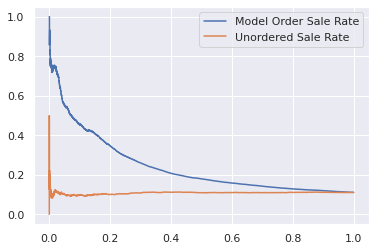

In [37]:
plt.plot(
    np.linspace(0,1,len(scores)),
    sale_rate,
    label = 'Model Order Sale Rate',
)

plt.plot(
    np.linspace(0,1,len(scores)),
    unorderd_rate,
    label = 'Unordered Sale Rate',
)
plt.legend()

In [38]:
qs = np.array([.01, .05, .10, .20, .50])


SalesComp = pd.DataFrame(dict(NumOfCustomers=1000*qs))
SalesComp['ModelOrderSales'] = SalesComp.NumOfCustomers * sale_rate.quantile(q= 1-qs).values
SalesComp['UnOrderSales'] = SalesComp.NumOfCustomers * y_test.mean()
SalesComp["Ratio"] = sale_rate.quantile(q= 1-qs).values / y_test.mean()


SalesComp.round(1)

,NumOfCustomers,ModelOrderSales,UnOrderSales,Ratio
0,10.0,7.5,1.1,6.7
1,50.0,27.6,5.6,5.0
2,100.0,45.6,11.1,4.1
3,200.0,69.4,22.3,3.1
4,500.0,90.0,55.6,1.6
